In [1]:
import numpy as np
from blportopt.config import (
    MARKET_TICKER,
    FF_FACTORS,
    ASSET_TICKERS,
)
from blportopt.data_utils import (
    get_data,
    MarketCapEvaluator,
)
from blportopt.fama_french_model import famafrench_regression_analysis
from blportopt.trading_strategy import backtest
from blportopt.covariance_estimator import (
    empirical_cov_calculate,
    factor_cov_calculate,
    annual_excess_asset_returns,
)
from blportopt.portfolio_construction import (
    empirical_rf_calculate,
    calc_optimal_portfolio_weights,
    efficient_frontier,
    plot_efficient_frontier,
)
from blportopt.views import generate_positions
from blportopt.black_litterman_model import (
    BlackLittermanModel,
    calc_asset_allocations,
)

# Asset Type

In [2]:
## Index Funds used in Portfolio Construction
# asset_type = "fund"

## Stocks used in Portfolio Construction
asset_type = "stock"

# 1. Load Data

In [3]:
ff_data, fund_open_data, fund_close_data, fund_returns, market_returns = get_data(asset_tickers=ASSET_TICKERS[asset_type], market_ticker=MARKET_TICKER, asset_type=asset_type)

display(ff_data.head())
display(fund_open_data.head())
display(fund_close_data.head())
display(fund_returns.head())
display(market_returns.head())

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Date,,,,,,,
1963-07,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,0.0090
1963-08,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,0.0101
1963-09,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,0.0019
1963-10,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,0.0312
1963-11,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,-0.0074


,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
Date,,,,,,,,,,,,,,,,,,,,
1985-05,0.073132,10.745808,1.188386,4.299487,13.8750,0.291864,0.0,0.388082,1.562934,0.000000,0.084393,0.519616,2.979550,9.414931,1.606485,0.544758,1.081950,6.595028,2.431613,0.841352
1985-06,0.058506,11.098276,1.228284,4.543862,13.3125,0.332229,0.0,0.414557,1.661871,5.467078,0.106171,0.589612,3.241594,10.123824,1.779130,0.539787,1.183157,7.249274,2.403486,0.956443
1985-07,0.062377,10.615745,1.285281,4.599728,13.0625,0.346654,0.0,0.436512,1.650330,0.000000,0.091652,0.579344,3.241791,10.589022,1.829294,0.557720,1.161304,7.587839,2.491321,1.006051
1985-08,0.054634,11.302014,1.320055,4.795265,15.0000,0.310901,0.0,0.430441,1.619555,0.000000,0.107986,0.573320,3.251645,10.234587,1.764851,0.581837,1.167548,7.846742,2.563185,0.905122
1985-09,0.051622,10.955608,1.325820,4.553173,13.2500,0.321448,0.0,0.433085,1.650646,6.013784,0.130672,0.570365,3.153111,10.367506,1.741363,0.575808,1.175856,7.750389,2.471542,0.911129


,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
Date,,,,,,,,,,,,,,,,,,,,
1985-05,0.059796,10.937128,1.228284,4.474788,13.250,0.325242,1.739792,0.413911,1.634837,5.467076,0.105263,0.582202,3.212479,10.168125,1.779799,0.539787,1.165653,7.106881,2.368454,0.952474
1985-06,0.061947,10.615742,1.279581,4.609041,13.000,0.339214,1.823636,0.433929,1.658024,6.013786,0.091652,0.580811,3.202772,10.544726,1.832638,0.551716,1.158183,7.607754,2.491321,1.010019
1985-07,0.054634,11.269847,1.305230,4.776641,14.875,0.307792,1.729311,0.420369,1.615708,6.013786,0.106171,0.566144,3.222085,10.190272,1.759065,0.580832,1.151939,7.846742,2.555201,0.900882
1985-08,0.051622,10.862371,1.325820,4.543862,13.250,0.321782,1.582581,0.433747,1.623402,6.013786,0.124320,0.568887,3.153110,10.411810,1.734654,0.575808,1.167548,7.647586,2.443410,0.911129
1985-09,0.054204,10.717678,1.299880,4.283148,13.125,0.297320,1.472534,0.412588,1.623265,5.467076,0.124320,0.560022,2.640731,9.459242,1.741363,0.560734,1.116120,7.468557,2.455389,0.985220


,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
Date,,,,,,,,,,,,,,,,,,,,
1985-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-06,0.035968,-0.029385,0.041763,0.030002,-0.018868,0.042959,0.048192,0.048362,0.014184,0.100000,-0.129310,-0.002389,-0.003021,0.037037,0.029688,0.022099,-0.006409,0.070477,0.051876,0.060416
1985-07,-0.118048,0.061617,0.020044,0.036363,0.144231,-0.092634,-0.051724,-0.031249,-0.025522,0.000000,0.158420,-0.025253,0.006030,-0.033614,-0.040146,0.052773,-0.005391,0.031414,0.025641,-0.108055
1985-08,-0.055128,-0.036156,0.015775,-0.048733,-0.109244,0.045455,-0.084849,0.031824,0.004762,0.000000,0.170939,0.004846,-0.021407,0.021740,-0.013877,-0.008651,0.013550,-0.025381,-0.043751,0.011375
1985-09,0.050012,-0.013321,-0.019565,-0.057377,-0.009434,-0.076021,-0.069536,-0.048781,-0.000084,-0.090909,0.000000,-0.015584,-0.162500,-0.091489,0.003868,-0.026178,-0.044048,-0.023410,0.004903,0.081318


,SPY
Date,
1993-02,NaN
1993-03,0.017593
1993-04,-0.020986
1993-05,0.026970
1993-06,-0.003456


# 2. Portfolio Selection - Backtest Factors

## 2a. Estimate R-squares

In [5]:
adj_rsq = famafrench_regression_analysis(asset_type=asset_type)
adj_rsq

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------

/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AAPL--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for IBM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PG--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for AMD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WMT--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BAC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for T--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for XOM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for RRC--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for BBY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for PFE--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JPM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for C--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MCD--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for KO--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for JNJ--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for WHR--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for MMM--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[self.rf_col].hist(bins=100, density=True, legend=True)
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/fama_french_model.py:238: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rolling_betas.groupby(["Group"])[factor].hist(bins=100, density=True, ax=ax, figsize=(10, 10), legend=True)


--------------------------------------------------Rolling Estimates of Sensitivity Factors for GIS--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------


,Mkt-RF,SMB,HML,RMW,CMA,Mom,Mkt-RF_SMB_HML_RMW_CMA_Mom
AAPL,0.248122,0.025804,0.085574,0.056898,0.142368,0.013115,0.351676
IBM,0.308222,0.020997,0.051712,0.071109,0.057911,0.102530,0.369324
PG,0.180413,0.007057,0.041888,0.045678,0.026859,0.010954,0.284616
GE,0.450043,0.062356,0.118816,0.055423,0.082693,0.111930,0.540846
AMD,0.265634,0.071669,0.033707,0.066608,0.049106,0.066979,0.306354
WMT,0.182189,0.010694,0.062585,0.034835,0.091831,0.007515,0.277672
BAC,0.346302,0.085648,0.145658,0.096632,0.031967,0.140196,0.567781
T,0.178541,0.039862,0.008759,0.032501,0.018712,0.049365,0.306607
XOM,0.251213,0.042096,0.042848,-0.001892,0.024130,0.068430,0.393998
RRC,0.071800,0.032796,0.008190,0.004081,0.007535,0.041474,0.136615


## 2b. Estimate Average Parameters

In [6]:
params_dict = famafrench_regression_analysis(asset_type=asset_type, rolling=False)

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------

In [7]:
# CAPM Model Parameters
params_dict['Mkt-RF']

,Alpha,Mkt-RF
AAPL,0.013094,1.342117
IBM,-0.000319,0.875186
PG,0.006098,0.480130
GE,-0.001125,1.189738
AMD,0.003469,2.087255
WMT,0.005862,0.659819
BAC,-0.000598,1.385871
T,0.003156,0.598317
XOM,0.003632,0.616775
RRC,0.006427,1.055818


In [8]:
# Fama-French 6 Factor Model Factor Loadings
params_dict['Mkt-RF_SMB_HML_RMW_CMA_Mom']

,Alpha,Mkt-RF,SMB,HML,RMW,CMA,Mom
AAPL,0.016594,1.129771,0.302297,-0.697793,0.257172,-0.676052,-0.117146
IBM,0.002249,0.815403,-0.255859,-0.272204,-0.063894,0.170658,-0.381994
PG,0.000781,0.699967,-0.210562,-0.323043,0.567923,0.762362,0.062224
GE,-0.000482,1.208767,-0.242299,0.452743,-0.115044,-0.075667,-0.149179
AMD,0.010368,1.785463,0.394063,-0.778771,-0.120603,0.255403,-0.826635
WMT,0.002678,0.786065,-0.304549,-0.242067,0.623199,-0.031409,0.077578
BAC,0.003494,1.272000,-0.136273,1.831882,-0.448410,-1.243592,-0.252011
T,-0.001023,0.817874,-0.413115,-0.022879,0.286118,0.767552,-0.021068
XOM,0.000055,0.771572,-0.036153,0.300372,0.177758,0.517935,0.034887
RRC,0.000713,1.205667,0.651209,0.366105,0.520994,0.762254,0.016747


# 3. Covariance Estimation

## 3 a. Risk-Free Rate

In [3]:
rf = empirical_rf_calculate(asset_type=asset_type)
rf

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Computing Average Risk-Free Returns of Assets--------------------------------------------------


0.030399136069114475

## 3 b. Empirical Returns & Covariance Matrix

In [4]:
mu_emp, cov_emp = empirical_cov_calculate(asset_type=asset_type)

display(mu_emp)
display(cov_emp)

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

AAPL    0.272682
IBM     0.071524
PG      0.114513
GE      0.088931
AMD     0.221336
WMT     0.127149
BAC     0.112139
T       0.089382
XOM     0.096684
RRC     0.168030
BBY     0.290536
PFE     0.099200
JPM     0.122249
C       0.086623
MCD     0.122729
KO      0.111908
JNJ     0.115236
WHR     0.100627
MMM     0.082880
GIS     0.095732
dtype: float64

,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
AAPL,0.179723,0.038285,0.008421,0.032728,0.113900,0.023083,0.033477,0.007462,0.015534,0.026446,0.059661,0.011131,0.033156,0.035224,0.023483,0.011500,0.017303,0.036750,0.022256,0.005514
IBM,0.038285,0.066922,0.006310,0.025661,0.059697,0.012248,0.025413,0.014554,0.015498,0.019246,0.034299,0.014877,0.030712,0.032682,0.016695,0.008154,0.013948,0.027684,0.018833,0.004032
PG,0.008421,0.006310,0.037553,0.015515,0.006519,0.014508,0.017369,0.011146,0.008363,0.013993,0.000688,0.014101,0.013667,0.020072,0.016408,0.020915,0.018516,0.022787,0.014087,0.014776
GE,0.032728,0.025661,0.015515,0.078048,0.054570,0.019577,0.054563,0.021236,0.021445,0.022009,0.032849,0.020392,0.043265,0.064053,0.020469,0.018453,0.017724,0.045372,0.025601,0.011025
AMD,0.113900,0.059697,0.006519,0.054570,0.399107,0.021720,0.070333,0.023065,0.020049,0.043380,0.101497,0.034330,0.072204,0.077362,0.027564,0.015765,0.019992,0.073105,0.032747,0.007254
WMT,0.023083,0.012248,0.014508,0.019577,0.021720,0.050525,0.021996,0.012029,0.007391,0.001837,0.031643,0.016102,0.021242,0.025992,0.018601,0.016812,0.017515,0.024187,0.014366,0.011993
BAC,0.033477,0.025413,0.017369,0.054563,0.070333,0.021996,0.134932,0.016548,0.020363,0.032580,0.047246,0.029745,0.081185,0.108005,0.024350,0.021385,0.021995,0.071050,0.030109,0.010629
T,0.007462,0.014554,0.011146,0.021236,0.023065,0.012029,0.016548,0.049334,0.016481,0.010872,0.014309,0.016577,0.014074,0.024155,0.017147,0.014926,0.013830,0.021764,0.014334,0.012547
XOM,0.015534,0.015498,0.008363,0.021445,0.020049,0.007391,0.020363,0.016481,0.040221,0.050728,0.012469,0.011876,0.017662,0.027801,0.014261,0.012396,0.012704,0.018820,0.016295,0.005685
RRC,0.026446,0.019246,0.013993,0.022009,0.043380,0.001837,0.032580,0.010872,0.050728,0.380588,0.027568,0.018534,0.032138,0.040569,0.017394,0.011047,0.019965,0.034898,0.028807,0.011781


## 3 c. Factor Model Evaluated Returns & Covariance Matrix

In [5]:
mu_f, cov_f = factor_cov_calculate(asset_type=asset_type)

display(mu_f)
display(cov_f)

--------------------------------------------------Computing Covariance Matrix based on Factor Loadings--------------------------------------------------
--------------------------------------------------Loading Time Series of Factors--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Fitting Fama-French Factor Model--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
------------------------------Asset returns Computed for Asset AAPL------------------------------
--------------------------------------------------F

AAPL    0.302976
IBM     0.101817
PG      0.144806
GE      0.119225
AMD     0.251629
WMT     0.157443
BAC     0.142432
T       0.119675
XOM     0.126977
RRC     0.198323
BBY     0.320829
PFE     0.129493
JPM     0.152542
C       0.116916
MCD     0.153022
KO      0.142202
JNJ     0.145530
WHR     0.130920
MMM     0.113174
GIS     0.126026
dtype: float64

,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
AAPL,0.179529,0.038225,0.008431,0.032777,0.113499,0.023127,0.033389,0.007477,0.015467,0.026212,0.059703,0.011122,0.033012,0.035219,0.023370,0.011543,0.017296,0.036533,0.022168,0.005491
IBM,0.038225,0.066996,0.006455,0.025845,0.059430,0.012425,0.025460,0.014703,0.015565,0.019146,0.034475,0.015003,0.030702,0.032811,0.016715,0.008331,0.014076,0.027601,0.018880,0.004144
PG,0.008431,0.006455,0.037769,0.015769,0.006322,0.014756,0.017487,0.011366,0.008500,0.013965,0.000935,0.014297,0.013728,0.020272,0.016499,0.021162,0.018715,0.022775,0.014204,0.014958
GE,0.032777,0.025845,0.015769,0.078341,0.054413,0.019864,0.054719,0.021494,0.021621,0.022019,0.033134,0.020627,0.043364,0.064292,0.020599,0.018739,0.017962,0.045398,0.025757,0.011246
AMD,0.113499,0.059430,0.006322,0.054413,0.398499,0.021557,0.070039,0.022874,0.019774,0.042939,0.101332,0.034114,0.071853,0.077150,0.027243,0.015601,0.019779,0.072680,0.032453,0.007024
WMT,0.023127,0.012425,0.014756,0.019864,0.021557,0.050806,0.022147,0.012282,0.007561,0.001841,0.031923,0.016331,0.021336,0.026225,0.018725,0.017092,0.017747,0.024207,0.014517,0.012208
BAC,0.033389,0.025460,0.017487,0.054719,0.070039,0.022147,0.134952,0.016670,0.020402,0.032453,0.047395,0.029843,0.081148,0.108107,0.024343,0.021535,0.022095,0.070939,0.030129,0.010713
T,0.007477,0.014703,0.011366,0.021494,0.022874,0.012282,0.016670,0.049559,0.016622,0.010848,0.014561,0.016777,0.014139,0.024359,0.017243,0.015179,0.014033,0.021756,0.014456,0.012734
XOM,0.015467,0.015565,0.008500,0.021621,0.019774,0.007561,0.020402,0.016622,0.040280,0.050621,0.012638,0.011994,0.017645,0.027923,0.014274,0.012565,0.012824,0.018730,0.016335,0.005788
RRC,0.026212,0.019146,0.013965,0.022019,0.042939,0.001841,0.032453,0.010848,0.050621,0.380315,0.027571,0.018486,0.031954,0.040525,0.017240,0.011051,0.019920,0.034641,0.028680,0.011719


# 4. Portfolio Optimization

In [6]:
risk_aversion=2.24
optimization_method = "volatility"
# optimization_method = "risk adjusted returns"
# optimization_method = "sharpe ratio"

## 4 a. Empirical Returns & Covariance Matrix

### Efficient Fronter Estimation

In [7]:
efport_emp = efficient_frontier(mu=mu_emp, cov=cov_emp, rf=rf, risk_aversion=risk_aversion, method=optimization_method)
display(efport_emp)

/var/folders/ff/9j4yz0593fl33s973slkvdv40000gn/T/ipykernel_27239/1046661935.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  efport_emp = efficient_frontier(mu=mu_emp, cov=cov_emp, rf=rf, risk_aversion=risk_aversion, method=optimization_method)


,targetrets,targetvols,targetsharpe
0,7.15,13.16,0.54
1,7.37,13.03,0.57
2,7.59,12.90,0.59
3,7.82,12.79,0.61
4,8.04,12.68,0.63
...,...,...,...
95,28.17,29.93,0.94
96,28.39,30.24,0.94
97,28.61,30.56,0.94
98,28.83,30.87,0.93


### Optimal Weights (Empirical Covariance)

In [8]:
targetret_emp = efport_emp.loc[efport_emp["targetsharpe"].argmax(), ["targetrets"]]
optimal_weights_emp = calc_optimal_portfolio_weights(mu=mu_emp, cov=cov_emp, rf=rf, tr=targetret_emp, risk_aversion=risk_aversion, method=optimization_method)
optimal_weights_emp

{'AAPL': 36.30895599315383,
 'IBM': -43.18395090015874,
 'PG': 25.775556809535676,
 'GE': -10.591928919974398,
 'AMD': 5.509939072922888,
 'WMT': 3.4398541294157967,
 'BAC': 11.305350951520754,
 'T': 1.4364238834385221,
 'XOM': -7.3371341837814645,
 'RRC': 7.258307211729463,
 'BBY': 22.408656783920264,
 'PFE': -5.341529132608679,
 'JPM': 5.810435326435983,
 'C': -17.459867541271016,
 'MCD': 4.773429538486314,
 'KO': 2.2297770050685117,
 'JNJ': 18.0361261391152,
 'WHR': -10.784452641949185,
 'MMM': -29.549929327796097,
 'GIS': -19.044020197203626}

## 4 b. Factor Model Asset Returns & Covariance Matrix

### Efficient Fronter Estimation

In [9]:
efport_f = efficient_frontier(mu=mu_f, cov=cov_f, rf=rf, risk_aversion=risk_aversion, method=optimization_method)
display(efport_f)

/var/folders/ff/9j4yz0593fl33s973slkvdv40000gn/T/ipykernel_27239/2364881993.py:1: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  efport_f = efficient_frontier(mu=mu_f, cov=cov_f, rf=rf, risk_aversion=risk_aversion, method=optimization_method)


,targetrets,targetvols,targetsharpe
0,10.18,13.22,0.77
1,10.40,13.09,0.79
2,10.62,12.97,0.82
3,10.85,12.85,0.84
4,11.07,12.74,0.87
...,...,...,...
95,31.20,29.94,1.04
96,31.42,30.25,1.04
97,31.64,30.56,1.04
98,31.86,30.88,1.03


### Optimal Weights (Factor Analysis)

In [10]:
targetret_f = efport_f.loc[efport_f["targetsharpe"].argmax(), ["targetrets"]]
optimal_weights_f = calc_optimal_portfolio_weights(mu=mu_f, cov=cov_f, rf=rf, tr=targetret_f, risk_aversion=risk_aversion, method=optimization_method)
optimal_weights_f

{'AAPL': 41.920293628839296,
 'IBM': -50.03605965088143,
 'PG': 29.793816071392083,
 'GE': -12.204811756582933,
 'AMD': 6.38177651923995,
 'WMT': 3.97645829388466,
 'BAC': 12.928081503770118,
 'T': 1.7433047089678464,
 'XOM': -8.380093103096694,
 'RRC': 8.36052004627428,
 'BBY': 25.890982850246843,
 'PFE': -6.397622668116666,
 'JPM': 6.994445629436074,
 'C': -20.108753570530652,
 'MCD': 5.5387158729272254,
 'KO': 2.208173361606963,
 'JNJ': 20.91540334687236,
 'WHR': -12.658281961836405,
 'MMM': -34.00082529814908,
 'GIS': -21.865523824263832}

# 5. Efficient Frontiers

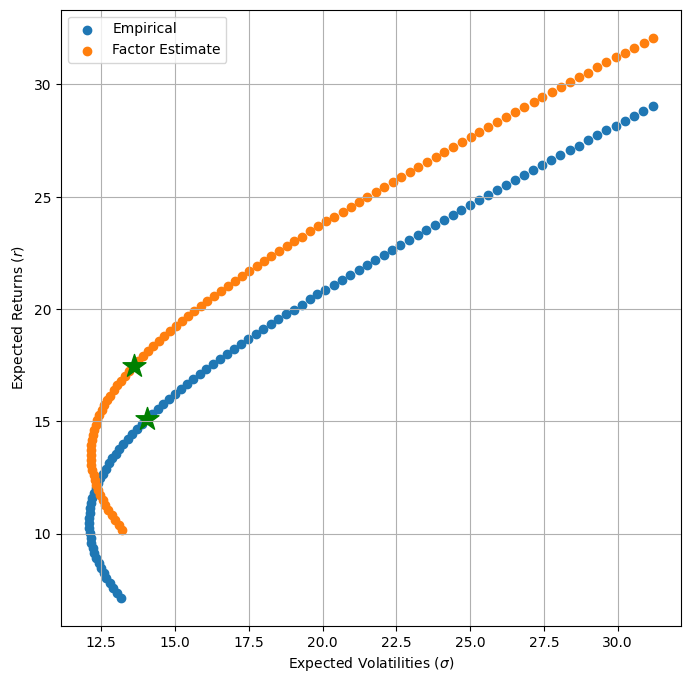

In [11]:
efport_dict = {"Empirical": efport_emp, "Factor Estimate": efport_f}

plot_efficient_frontier(efport_dict=efport_dict)

# 6. Market Capitalization

In [13]:
if asset_type == "stock":
    mcap_eval = MarketCapEvaluator(tickers=ASSET_TICKERS["stock"])
    market_cap_stocks = mcap_eval.compute_market_cap()
    print(market_cap_stocks)

{'AAPL': 0.4331292998627732, 'IBM': 0.021584515875792014, 'PG': 0.05324811112573221, 'GE': 0.016982467870099858, 'AMD': 0.03400385050044751, 'WMT': 0.06511079873710349, 'BAC': 0.03770753667099052, 'T': 0.016837746592273252, 'XOM': 0.06494666398301878, 'RRC': 0.0010775520968735407, 'BBY': 0.0023947554975939527, 'PFE': 0.026336498219251575, 'JPM': 0.07025966987364891, 'C': 0.014054193494423335, 'MCD': 0.031139102561226848, 'KO': 0.03828419797749938, 'JNJ': 0.05914901542122548, 'WHR': 0.0010020921138545566, 'MMM': 0.006989972079959415, 'GIS': 0.005761959446212401}


# 7. Evaluate MSR Portfolio Performance

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculating Historical Returns of 20 Equities (Stocks/Funds)--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Loading Historical Prices of SPY--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
--------------------------------------------------Calculate Alpha : AAPL (Fama French Model)----------------------------------

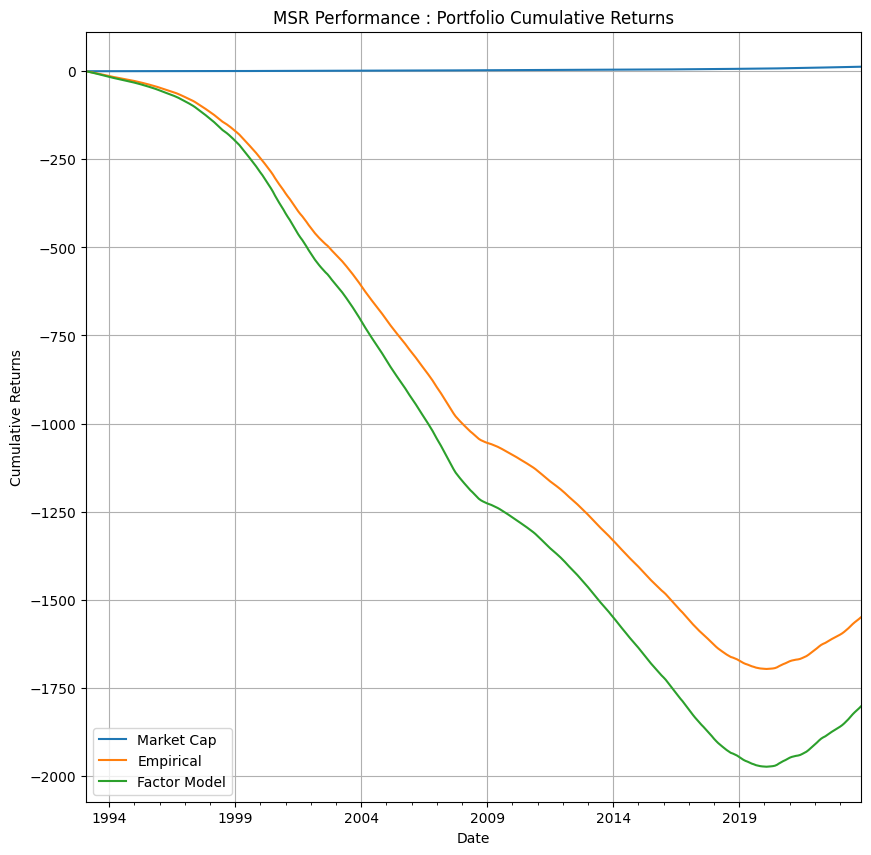

,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,12.749496,0.085561,0.006696,12.778356,-0.135971


,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,-1549.509492,0.471084,1.462417,0.322127,0.247367


,Total Profit,Annual Returns,Annual Volatility,Sharpe Ratio,Information Ratio
0,-1802.348272,0.330557,0.782299,0.422546,0.280046


In [14]:
if asset_type == "stock":
    allocations_dict = {
        "Market Cap": market_cap_stocks,
        "Empirical" : optimal_weights_emp,
        "Factor Model": optimal_weights_f,
    }
elif asset_type == "fund":
    allocations_dict = {
        "Empirical" : optimal_weights_emp,
        "Factor Model": optimal_weights_f,
    }
    
performance = backtest(allocations_dict, factors=FF_FACTORS, asset_type=asset_type, topn=len(ASSET_TICKERS[asset_type]))

if asset_type == "stock":
    display(performance["Market Cap"])
display(performance["Empirical"])
display(performance["Factor Model"])

# Black Litterman Model

In [13]:
asset_returns = annual_excess_asset_returns(tickers=ASSET_TICKERS[asset_type])
asset_returns

--------------------------------------------------Loading Time Series of Factors--------------------------------------------------


/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename, start=self.start)[0]
/Users/souratoshkhan/CQF/BlPortfolioConstruction/blportopt/data_utils.py:168: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pdr.get_data_famafrench(filename

,AAPL,IBM,PG,GE,AMD,WMT,BAC,T,XOM,RRC,BBY,PFE,JPM,C,MCD,KO,JNJ,WHR,MMM,GIS
Year,,,,,,,,,,,,,,,,,,,,
1985,0.032391,0.026697,0.035765,0.025274,0.012533,0.025897,0.009235,0.011230,0.004512,-0.091989,0.104858,0.001033,0.016648,0.002987,0.024562,0.031758,0.013972,0.011209,0.025709,0.000898
1986,0.052305,-0.022873,0.008075,0.013478,-0.054853,0.030778,-0.004944,0.027231,0.021425,-0.049142,0.047037,0.016442,-0.003355,0.026054,0.008762,0.024594,0.019121,0.030923,0.021375,0.029148
1987,0.078402,-0.001378,0.010825,0.004649,-0.007701,0.012652,-0.013735,-0.004032,0.009987,0.120357,-0.027019,-0.019270,-0.049672,-0.038485,0.006563,0.001452,0.011836,-0.019278,0.012015,0.013937
1988,-0.005595,0.004659,0.000063,-0.000093,-0.003569,0.012603,0.040500,0.016996,0.011703,-0.005150,0.016509,0.017849,0.039023,-0.000606,0.004167,0.010982,0.008250,0.001591,-0.004148,0.002007
1989,-0.010965,-0.023187,0.037985,0.029390,-0.011010,0.025439,0.045273,0.039774,0.008981,-0.006725,-0.024655,0.013198,0.000197,0.019264,0.025986,0.043726,0.024380,0.022445,0.018556,0.025116
1990,0.018776,0.014249,0.016179,-0.011367,-0.032484,0.021721,-0.047784,-0.009260,0.001511,-0.022217,0.010432,0.013123,-0.069766,-0.014750,-0.016452,0.013972,0.013458,-0.025345,0.004224,0.024765
1991,0.028528,-0.018138,0.006163,0.024845,0.125420,0.054925,0.055079,0.014439,0.013597,0.030834,0.125904,0.064226,0.065542,0.048041,0.020617,0.044959,0.039718,0.044115,0.008248,0.034320
1992,0.007826,-0.039775,0.011925,0.009564,0.021459,0.005048,0.021859,0.014748,0.002132,-0.006570,0.089693,-0.011892,0.056968,0.018181,0.020724,0.002929,-0.010579,0.013340,0.004862,-0.006288
1993,-0.046159,0.012924,0.006250,0.017517,0.009344,-0.019776,-0.002360,0.013078,0.004340,0.055711,0.062636,-0.001345,0.004871,0.043307,0.012626,0.004957,-0.007669,0.035451,0.007432,-0.008984


## 1. Generate Investor Views based on Earnings Reports

## a. Empirical Returns

In [15]:
Investor_Views = ["WMT outperforms T", "WMT returns", "XOM outperforms KO"]

P_emp, Q_emp = generate_positions(investor_views=Investor_Views, returns=mu_emp)

print(P_emp)
print(Q_emp)

--------------------------------------------------Constructing Absolute & Relative Investor Views!--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
[[ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]]
[ 0.03776739  0.12714908 -0.01522483]


## b. Factor Model Returns

In [16]:
P_f, Q_f = generate_positions(investor_views=Investor_Views, returns=mu_f)

print(P_f)
print(Q_f)

--------------------------------------------------Constructing Absolute & Relative Investor Views!--------------------------------------------------
--------------------------------------------------Done!--------------------------------------------------
[[ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]]
[ 0.03776739  0.15744259 -0.01522483]


## 2. Posterior Returns and Asset Allocation Computation

## a. Empirical Returns

### $\lambda =2.24$

In [21]:
sharpe_ratio=0.5
risk_aversion=2.24

bl_model = BlackLittermanModel(cov=cov_emp, weights=np.array(list(optimal_weights_emp.values())), risk_aversion=risk_aversion, T=len(asset_returns), position_matrix=P_emp, return_vector=Q_emp)
posterior_returns = bl_model.posterior_return
print(f"posterior returns for lambda = {risk_aversion} : {posterior_returns}")

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_emp, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")


posterior returns for lambda = 2.24 : [13.13138113 -2.67760942  0.50025518 -1.40058211  9.28385161  0.61061917
  0.3054571  -0.70665448 -0.31941639  5.61125429 14.41753056 -0.62375083
  1.07568084 -1.73697289  1.214416    0.16231984  0.56618176 -0.57785536
 -1.88740729 -0.88142494]
Optimal Weights for lambda = 2.24 : [ 36.30895599 -43.1839509   25.77555681 -10.59192892   5.50993907
  -8.3675916   11.30535095   8.97198526  -3.41520451   7.25830721
  22.40865678  -5.34152913   5.81043533 -17.45986754   4.77342954
  -1.69215267  18.03612614 -10.78445264 -29.54992933 -19.0440202 ]


### $\lambda = 0.1$

In [22]:
risk_aversion=0.1

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_emp, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")

Optimal Weights for lambda = 0.1 : [ 813.32061425 -967.32050016  577.37247253 -237.25920781  123.42263523
 -187.43405188  253.23986131  200.97246993  -76.50058094  162.58608154
  501.95391196 -119.65025257  130.15375131 -391.10103292  106.92482166
  -37.90421986  404.00922552 -241.57173918 -661.91841694 -426.58605242]


### $\lambda = 6.0$

In [23]:
risk_aversion=6.0

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_emp, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")

Optimal Weights for lambda = 6.0 : [ 13.55534357 -16.12200834   9.62287454  -3.95432013   2.05704392
  -3.12390086   4.22066436   3.34954117  -1.27500968   2.70976803
   8.36589853  -1.99417088   2.16922919  -6.51835055   1.78208036
  -0.631737     6.73348709  -4.02619565 -11.03197362  -7.10976754]


## b. Factor Model Returns

### $\lambda =2.24$

In [24]:
sharpe_ratio=0.5
risk_aversion=2.24

bl_model = BlackLittermanModel(cov=cov_f, weights=np.array(list(optimal_weights_f.values())), risk_aversion=risk_aversion, T=len(asset_returns), position_matrix=P_f, return_vector=Q_f)
posterior_returns = bl_model.posterior_return
print(f"posterior returns for lambda = {risk_aversion} : {posterior_returns}")

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_f, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")


posterior returns for lambda = 2.24 : [15.14883461 -3.11815109  0.55997338 -1.63034997 10.71128521  0.69985946
  0.3300264  -0.82393216 -0.3852442   6.45003683 16.6403263  -0.75445603
  1.2513625  -2.01887201  1.3885516   0.1607296   0.63340185 -0.71016077
 -2.19584122 -1.02735498]
Optimal Weights for lambda = 2.24 : [ 41.92029363 -50.03605965  29.79381607 -12.20481176   6.38177652
  -9.54155132  12.9280815   10.495139    -3.95121175   8.36052005
  25.89098285  -6.39762267   6.99444563 -20.10875357   5.53871587
  -2.22070799  20.91540335 -12.65828196 -34.0008253  -21.86552382]


### $\lambda = 0.1$

In [25]:
risk_aversion=0.1

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_f, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")

Optimal Weights for lambda = 0.1 : [  939.01457729 -1120.80773618   667.38148     -273.38778335
   142.95179403  -213.73074963   289.58902568   235.0911135
   -88.50714329   187.27564904   579.95801585  -143.30674777
   156.6755821   -450.43607998   124.06723555   -49.74385892
   468.50503497  -283.54551595  -761.61848668  -489.78773366]


### $\lambda = 6.0$

In [26]:
risk_aversion=6.0

optimal_weights = calc_asset_allocations(risk_aversion=risk_aversion, cov=cov_f, posterior_returns=posterior_returns)
print(f"Optimal Weights for lambda = {risk_aversion} : {optimal_weights}")

Optimal Weights for lambda = 6.0 : [ 15.65024295 -18.68012894  11.12302467  -4.55646306   2.3825299
  -3.56217916   4.82648376   3.91818522  -1.47511905   3.12126082
   9.66596693  -2.3884458    2.6112597   -7.507268     2.06778726
  -0.82906432   7.80841725  -4.7257586  -12.69364144  -8.16312889]
